<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/MAB_movielens_thompson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Arm Bandits - Thompson Sampling

#### Installation

In [2]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

--2021-02-25 07:46:34--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3657 (3.6K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   3.57K  --.-KB/s    in 0s      

2021-02-25 07:46:34 (45.6 MB/s) - ‘./utils.py’ saved [3657/3657]



##### Imports

In [3]:
from scipy.stats import norm
from tqdm.notebook import trange
from typing import Any, Dict, List, Text, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import zipfile

from utils import load_movielens_data
from utils import plot_actions, plot_cumsum, plot_pdf

# Apply the default theme
sns.set_theme()

#### Downloading the [MovieLens](https://grouplens.org/datasets/movielens/) (100K) dataset.

**Dataset info**

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.

This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th,
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.

In [4]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-25 07:46:40--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  26.3MB/s    in 0.2s    

2021-02-25 07:46:40 (26.3 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



## Environment

Implementation of the environment uses **MovieLens 100K dataset**. As described above, the dataset contains 100000 ratings from 943 users and 1682 movies. The environment can consider only the first $n$ of the dataset's movies. It can be set-up by `num_actions`. The number of "known" movies for the environment is equal to actions/arms.

> Users without a rating (after selecting first $n$ movies) are removed from the environment.

In [5]:
class MovielensEnvironment(object):
  def __init__(
      self, 
      data_dir: Text,
      rank_k: int, 
      batch_size: int = 1,
      num_movies: int = 20
  ):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)
    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size)
    self._previous_users = np.zeros(batch_size)

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)
    
    #self._params = params
    #self._observe()
    self.reset()

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def best_arm(self) -> int:
    return np.argmax(np.sum(env._data_matrix, axis=0))

  @property
  def n_arms(self) -> int:
    return self._data_matrix.shape[1]

  def reset(self):
    return self._observe()

  def _observe(self) -> np.ndarray:
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def step(self, action: List[int]) -> Tuple[int, float]:
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    return np.array(rewards)
  
  def best_action(self):
    return np.argmax(self._params)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

Now we are equipped to initialize our environment.

In [6]:
env = MovielensEnvironment('./ml-100k/u.data', rank_k=20, batch_size=1, num_movies=20)

Below we can check what this environment produces.

In [12]:
env.reset()

action = np.zeros(1, dtype=np.int32)
reward = env.step(action)

print(f'Action={action} (optimal={env.compute_optimal_action()})')
print(f'Reward={reward} (optimal={env.compute_optimal_reward()})')

Action=[0] (optimal=[11])
Reward=[4.] (optimal=[2.])


## Policy

In [ ]:
class GaussianPolicy(object):
  def __init__(self, tau: List[float], mu: List[float], batch_size: int = 1):
    self._tau0 = tau
    self._mu0 = mu
    self._n = len(tau)
    self._batch_size = batch_size

  def action(self) -> int:
    sample = (np.random.randn(self._batch_size, self._n) / np.sqrt(self._tau0)) + self._mu0
    return np.argmax(sample, axis=1)

In [ ]:
p = GaussianPolicy([1, 10, 5], [1, 1, 1], batch_size=10)
print(f'GaussianPolicy - action: {p.action()}')

GaussianPolicy - action: [2 0 2 0 2 0 1 1 1 0]


## Agent

In [ ]:
class GaussianThompsonSamplingAgent(object):
  
  def __init__(self, n: int, batch_size: int = 1):
    self._batch_size = batch_size
    self._n = n

    self.reset()

    self.policy = GaussianPolicy(self._tau0, self._mu0, batch_size=batch_size)

  def reset(self):
    self._tau0 = [0.0001] * self._n
    self._mu0 = [1] * self._n
    self._Q = [0] * self._n

    self._counts = [0] * self._n
    self._values = [0.0] * self._n

  def train(self, experience: Dict[str, float]):
    action = experience['action']
    reward = experience['reward']
    # Update average/mean value/reward for chosen action
    self._Q[action] += reward
    self._counts[action] += 1
    value = self._values[action]
    n = self._counts[action]
    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward

    tau0 = self._tau0[action]
    mu0 = self._mu0[action]
    Q = self._Q[action] / self._counts[action]
    
    self._mu0[action] = ((tau0 * mu0) + (n * Q)) / (tau0 + n)        
    self._tau0[action] += 1

In [ ]:
a = GaussianThompsonSamplingAgent(3, batch_size=10)

experience = {'action': 2, 'reward': 1}
a.train(experience)
print(f'values={a._tau0}')

experience = {'action': 2, 'reward': 0}
a.train(experience)
print(f'values={a._tau0}')

values=[0.0001, 0.0001, 1.0001]
values=[0.0001, 0.0001, 2.0000999999999998]


## Training

In [ ]:
def run(environment: object, agent: object, trials=100):
  trajectory = []

  experience = {'trial': 0, 'action': -1, 'observation': 0, 'reward': 0}

  for i in range(trials):
    experience['trial'] = i + 1
    actions = agent.policy.action()
    rewards = environment.step(actions)

    for action, reward in zip(actions, rewards):
      experience['action'] = action
      experience['reward'] = reward
      agent.train(experience)

      trajectory.append(experience.copy())
    
  df_trajectory = pd.DataFrame.from_dict(trajectory)
  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'})

In [ ]:
environment = MovielensEnvironment('./ml-100k/u.data', rank_k=20, batch_size=10, num_movies=20)
step = environment.reset()

agent = GaussianThompsonSamplingAgent(
    environment.n_arms, batch_size=environment.batch_size)
experience = {'action': [-1], 'reward': [0]}

df_trajectory = run(environment, agent, trials=100)

print(f'\nvalues={agent._values}')
print(f'best action={np.argmax(agent._values)}')


values=[3.094269870609997, 1.4999999999999896, -9.328557718562103e-16, -8.148286833142825e-15, -2.787889341202202e-15, 7.151400918742727e-16, 2.744769874476985, 1.4444444444444395, 2.4186046511628048, 1.7450709505373673e-15, 2.5274725274725047, 2.714285714285686, 5.453331426389314e-15, 1.0000000000000149, 1.5156553261459753e-14, 0.8000000000000034, -8.214033017423508e-15, 0.9999999999999967, 1.2811751813625792e-14, 2.6413660696418915e-15]
best action=0


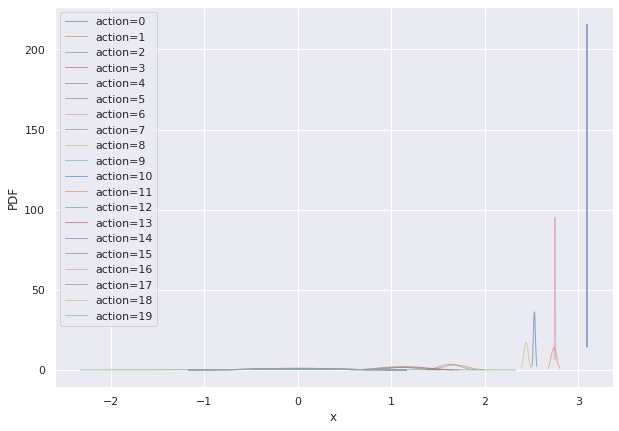

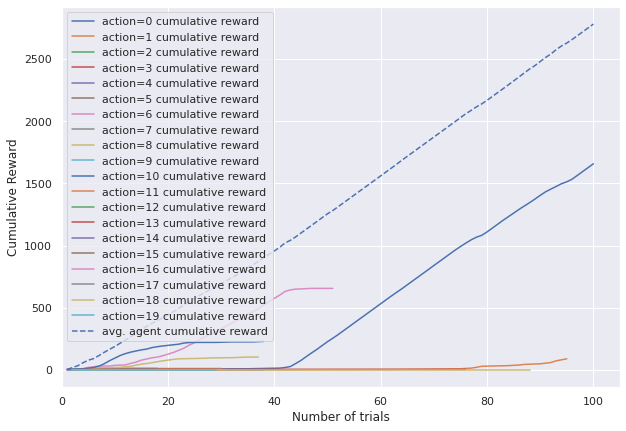

In [ ]:
params = {
    'mu': np.array(agent._mu0), 
    'tau': np.array(agent._tau0)
}

plot_pdf(params, type=1)
plot_cumsum(df_trajectory, show_actions=True)

#### Multiple runs

In [ ]:
def experiment(epochs: int = 1, trials: int = 10, batch_size: int = 1):
  trajectories = []
  
  environment = MovielensEnvironment(
      './ml-100k/u.data', rank_k=20, batch_size=batch_size, num_movies=20)
  params = {
      'best_action': environment.best_arm,
      'mu': [],
      'tau': [],
  }
  
  for epoch in trange(epochs):
    step = environment.reset()
    agent = GaussianThompsonSamplingAgent(
        environment.n_arms, batch_size=environment.batch_size)
    
    df = run(environment, agent, trials=trials)
    df['epoch'] = epoch + 1

    params['mu'].append(agent._mu0)
    params['tau'].append(agent._tau0)

    trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params

In [ ]:
df_trajectory, params = experiment(epochs=250, trials=500, batch_size=200)

params = {
    'mu': np.array(params['mu']).mean(axis=0), 
    'tau': np.array(params['tau']).mean(axis=0)
}

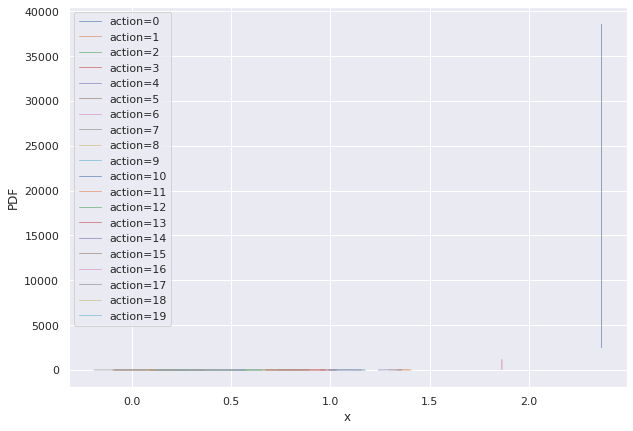

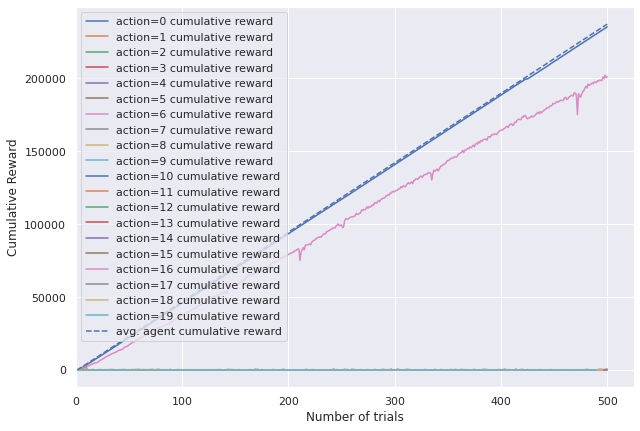

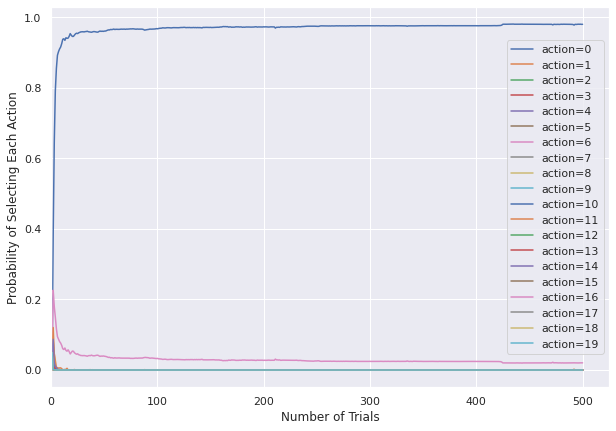

In [ ]:
plot_pdf(params, type=1)
plot_cumsum(df_trajectory, show_actions=True)
plot_actions(df_trajectory)